# Make Water Vapor Profile

In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_DTYPE_API'] = '1'
import numpy as np
import matplotlib.pyplot as plt
import climlab
import xarray as xr
import scipy.integrate as sp 
import matplotlib.offsetbox as offsetbox
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

/data/keeling/a/rytam2/miniconda3/envs/rrtmg/lib/python3.11/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)


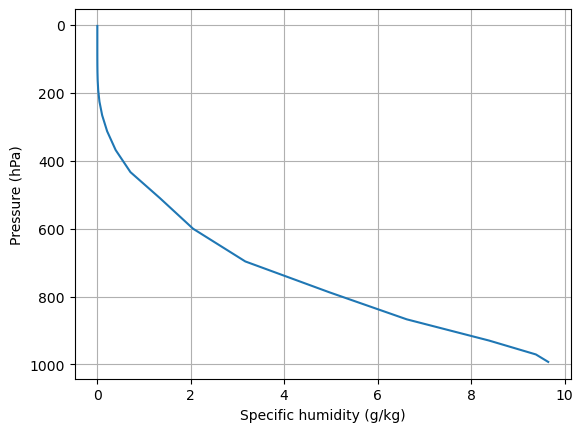

In [2]:
#  Load the model output as we have done before
cesm_data_path = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"
atm_control = xr.open_dataset(cesm_data_path + "cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc")
#  The specific humidity is stored in the variable called Q in this dataset:
atm_control.Q

# Take global, annual average of the specific humidity
weight_factor = atm_control.gw / atm_control.gw.mean(dim='lat')
Qglobal = (atm_control.Q * weight_factor).mean(dim=('lat','lon','time'))
# Take a look at what we just calculated ... it should be one-dimensional (vertical levels)
Qglobal

fig, ax = plt.subplots()
#  Multiply Qglobal by 1000 to put in units of grams water vapor per kg of air
ax.plot(Qglobal*1000., Qglobal.lev)
ax.invert_yaxis()
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Specific humidity (g/kg)')
ax.grid()

In [3]:
import climlab
#  Make a model on same vertical domain as the GCM
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
mystate

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.  , 203.12, 206.24, 209.36, 212.48, 215.6 , 218.72, 221.84,
       224.96, 228.08, 231.2 , 234.32, 237.44, 240.56, 243.68, 246.8 ,
       249.92, 253.04, 256.16, 259.28, 262.4 , 265.52, 268.64, 271.76,
       274.88, 278.  ])})

## B. All-sky conditions 
with cloud included


cloud profile like https://github.com/climlab/climlab/blob/9584063ae4dca19f8fb3ffdb5aa399eaff18fdba/climlab/tests/test_rrtm.py#L65

In [4]:

mystate
lev = Qglobal.lev
cldfrac = 0.5  # layer cloud fraction
r_liq = 19.  # Cloud water drop effective radius (microns)
clwp = 60.  # in-cloud liquid water path (g/m2)
#  The cloud fraction is a Gaussian bump centered at level i
i = 18
cldfrac = np.array(cldfrac*(np.exp(-(lev-lev[i])**2/(2*i)**2))**0.1)
mycloud = {'cldfrac': np.zeros_like(mystate.Tatm) + cldfrac,
            'clwp': np.zeros_like(mystate.Tatm) + clwp,
            'r_liq': np.zeros_like(mystate.Tatm) + r_liq,
            }


In [5]:
mycloud

{'cldfrac': Field([1.22517496e-09, 1.65311521e-09, 2.74567790e-09, 5.85210419e-09,
        1.56528588e-08, 4.89692961e-08, 1.58370770e-07, 4.42281198e-07,
        1.16817763e-06, 3.50143757e-06, 1.19705432e-05, 4.66473907e-05,
        2.05149840e-04, 9.93713307e-04, 5.06197201e-03, 2.50653168e-02,
        1.06344343e-01, 3.18090722e-01, 5.00000000e-01, 2.67374464e-01,
        3.43075591e-02, 1.32790925e-03, 2.72363751e-05, 6.46273470e-07,
        4.02813588e-08, 8.13667955e-09]),
 'clwp': Field([60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.,
        60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60., 60.]),
 'r_liq': Field([19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.,
        19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19., 19.])}

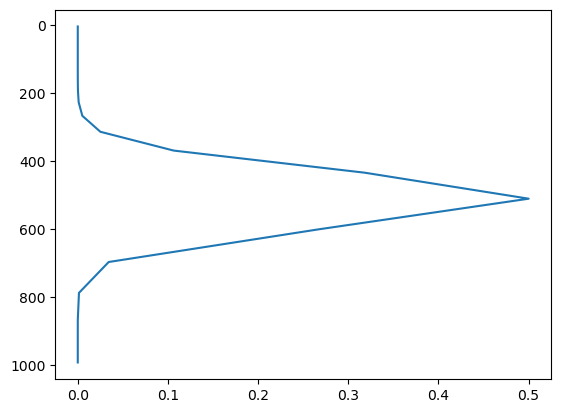

In [6]:
plt.plot(cldfrac,lev)
plt.gca().invert_yaxis()

Explicitly call the lower level models to do McICA, instead of using climlab top level wrapper

In [7]:
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
from __future__ import division, print_function, absolute_import
import numpy as np
import warnings
from climlab import constants as const
from climlab.radiation.radiation import _Radiation_SW
from climlab.radiation.rrtm.utils import _prepare_general_arguments
from climlab.radiation.rrtm.utils import _climlab_to_rrtm, _climlab_to_rrtm_sfc, _rrtm_to_climlab

In [8]:
# modified compute code that include mcica.

# short wave part
def compute_sw(radmodel,nmcica=100):
    # get input to rrtmg sw
    (ncol, nlay, icld, iaer, permuteseed, irng,
            play, plev, tlay, tlev, tsfc,
            h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
            aldif, aldir, asdif, asdir, coszen, adjes, dyofyr, scon, isolvar,
            indsolvar, bndsolvar, solcycfrac,
            inflgsw, iceflgsw, liqflgsw,
            cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc,
            tauaer, ssaaer, asmaer, ecaer,) = radmodel._prepare_sw_arguments()

    _swuflx, _swdflx, _swhr, _swuflxc, _swdflxc, _swhrc = [],[],[],[],[],[]
    for i in range(nmcica):
            (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl,
            ssacmcl, asmcmcl, fsfcmcl) = rrtmg_sw.climlab_mcica_subcol_sw(
                            ncol, nlay, icld, permuteseed+1000*i, irng, play, # permuteseed should have large spacing
                            cldfrac, ciwp, clwp, reic, relq, tauc, ssac, asmc, fsfc)

            (swuflx, swdflx, swhr, swuflxc, swdflxc, swhrc) = \
                    rrtmg_sw.climlab_rrtmg_sw(ncol, nlay, icld, iaer,
                        play, plev, tlay, tlev, tsfc,
                        h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                        asdir, asdif, aldir, aldif,
                        coszen, adjes, dyofyr, scon, isolvar,
                        inflgsw, iceflgsw, liqflgsw, cldfmcl,
                        taucmcl, ssacmcl, asmcmcl, fsfcmcl,
                        ciwpmcl, clwpmcl, reicmcl, relqmcl,
                        tauaer, ssaaer, asmaer, ecaer,
                        bndsolvar, indsolvar, solcycfrac)
            _swuflx.append(swuflx) 
            _swdflx.append(swdflx)
            _swhr.append(swhr)
            _swuflxc.append(swuflxc)
            _swdflxc.append(swdflxc)
            _swhrc.append(swhrc)
    swuflx = np.mean(np.array(_swuflx),axis=0)
    swdflx = np.mean(np.array(_swdflx),axis=0)
    swhr = np.mean(np.array(_swhr),axis=0)
    swuflxc = np.mean(np.array(_swuflxc),axis=0)
    swdflxc = np.mean(np.array(_swdflxc),axis=0)
    swhrc = np.mean(np.array(_swhrc),axis=0)
    
    #  Output is all (ncol,nlay+1) or (ncol,nlay)
    radmodel.SW_flux_up = _rrtm_to_climlab(swuflx) + 0.*radmodel.SW_flux_up
    radmodel.SW_flux_down = _rrtm_to_climlab(swdflx) + 0.*radmodel.SW_flux_down
    radmodel.SW_flux_up_clr = _rrtm_to_climlab(swuflxc) + 0.*radmodel.SW_flux_up_clr
    radmodel.SW_flux_down_clr = _rrtm_to_climlab(swdflxc) + 0.*radmodel.SW_flux_down_clr
    #  Compute quantities derived from fluxes, including ASR
    radmodel._compute_SW_flux_diagnostics()
    #  calculate heating rates from flux divergence
    SWheating_Wm2 = np.array(-np.diff(radmodel.SW_flux_net, axis=-1)) + 0.*radmodel.Tatm
    SWheating_clr_Wm2 = np.array(-np.diff(radmodel.SW_flux_net_clr, axis=-1)) + 0.*radmodel.Tatm
    radmodel.heating_rate['Ts'] = np.array(radmodel.SW_flux_net[..., -1, np.newaxis]) + 0.*radmodel.Ts
    radmodel.heating_rate['Tatm'] = SWheating_Wm2
    #  Convert to K / day
    Catm = radmodel.Tatm.domain.heat_capacity
    radmodel.TdotSW = SWheating_Wm2 / Catm * const.seconds_per_day
    radmodel.TdotSW_clr = SWheating_clr_Wm2 / Catm * const.seconds_per_day

# longwave part
def compute_lw(radmodel,nmcica=100):
    (ncol, nlay, icld, ispec, permuteseed, irng, idrv, cp,
                play, plev, tlay, tlev, tsfc,
                h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                inflglw, iceflglw, liqflglw,
                cldfrac, ciwp, clwp, reic, relq, tauc, tauaer,) = radmodel._prepare_lw_arguments()

    _uflx, _dflx, _uflxc, _dflxc = [],[],[],[]
    _olr_sr,_hr,_hrc,_duflx_dt,_duflxc_dt = [],[],[],[],[]
    for i in range(nmcica):
        #  Call the Monte Carlo Independent Column Approximation (McICA, Pincus et al., JC, 2003)
        (cldfmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl, taucmcl) = \
            rrtmg_lw.climlab_mcica_subcol_lw(
                        ncol, nlay, icld,
                        permuteseed+1000*i, irng, play, # permuteseed should have large spacing
                        cldfrac, ciwp, clwp, reic, relq, tauc)
            #  Call the RRTMG_LW driver to compute radiative fluxes
        (olr_sr, uflx, dflx, hr, uflxc, dflxc, hrc, duflx_dt, duflxc_dt) = \
            rrtmg_lw.climlab_rrtmg_lw(ncol, nlay, icld, ispec, idrv,
                    play, plev, tlay, tlev, tsfc,
                    h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                    cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                    inflglw, iceflglw, liqflglw, cldfmcl,
                    taucmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl,
                    tauaer)
        _uflx.append(uflx) 
        _dflx.append(dflx)
        _uflxc.append(uflxc)
        _dflxc.append(dflxc)
        _olr_sr.append(olr_sr)
        _hr.append(hr)
        _hrc.append(hrc)
        _duflx_dt.append(duflx_dt)
        _duflxc_dt.append(duflxc_dt)
    uflx = np.mean(np.array(_uflx),axis=0)
    dflx = np.mean(np.array(_dflx),axis=0)
    uflxc = np.mean(np.array(_uflxc),axis=0)
    dflxc = np.mean(np.array(_dflxc),axis=0)
    olr_sr = np.mean(np.array(_olr_sr),axis=0)
    hr = np.mean(np.array(_hr),axis=0)
    hrc = np.mean(np.array(_hrc),axis=0)
    duflx_dt = np.mean(np.array(_duflx_dt),axis=0)
    duflxc_dt = np.mean(np.array(_duflxc_dt),axis=0)
    
    #  Output is all (ncol,nlay+1) or (ncol,nlay)
    radmodel.LW_flux_up = _rrtm_to_climlab(uflx) + 0.*radmodel.LW_flux_up
    radmodel.LW_flux_down = _rrtm_to_climlab(dflx) + 0.*radmodel.LW_flux_down
    radmodel.LW_flux_up_clr = _rrtm_to_climlab(uflxc) + 0.*radmodel.LW_flux_up_clr
    radmodel.LW_flux_down_clr = _rrtm_to_climlab(dflxc) + 0.*radmodel.LW_flux_down_clr
    #  Compute quantities derived from fluxes, including OLR
    radmodel._compute_LW_flux_diagnostics()
    # Except for spectrally-decomposed TOA flux, olr_sr (ncol, nbndlw)
    if radmodel.return_spectral_olr:
        #  Need to deal with broadcasting for two different cases: single column and latitude axis
        # case single column: self.OLR is (1,),  self.OLR_spectral is (1, nbndlw),  olr_sr is (1,nbndlw)
        #  squeeze olr_sr down to (nbndlw,)
        # then use np.squeeze(olr_sr)[..., np.newaxis, :] to get back to (1, nbndlw)
        # case latitude axis: self.OLR is (num_lat,1), self.OLR_spectral is (num_lat, 1, nbndlw), olr_sr is (num_lat, nbndlw)
        #  np.squeeze(olr_sr) has no effect in this case
        # add the newaxis because the domain has a size-1 depth axis ---> (num_lat, 1, nbndlw)
        radmodel.OLR_spectral = np.squeeze(olr_sr)[...,np.newaxis,:] + 0.*radmodel.OLR_spectral
    #  calculate heating rates from flux divergence
    LWheating_Wm2 = np.array(np.diff(radmodel.LW_flux_net, axis=-1)) + 0.*radmodel.Tatm
    LWheating_clr_Wm2 = np.array(np.diff(radmodel.LW_flux_net_clr, axis=-1)) + 0.*radmodel.Tatm
    radmodel.heating_rate['Ts'] = np.array(-radmodel.LW_flux_net[..., -1, np.newaxis]) + 0.*radmodel.Ts
    radmodel.heating_rate['Tatm'] = LWheating_Wm2
    #  Convert to K / day
    Catm = radmodel.Tatm.domain.heat_capacity
    radmodel.TdotLW = LWheating_Wm2 / Catm * const.seconds_per_day
    radmodel.TdotLW_clr = LWheating_clr_Wm2 / Catm * const.seconds_per_day

In [9]:
def step_model(radmodel_sw,radmodel_lw,nmcica=1):
    # iterate model, get heating rate
    compute_sw(radmodel_sw,nmcica)
    dTs_sw = radmodel_sw.heating_rate['Ts']/radmodel_sw.Ts.domain.heat_capacity*86400
    dTa_sw = radmodel_sw.heating_rate['Tatm']/radmodel_sw.Tatm.domain.heat_capacity*86400
    compute_lw(radmodel_lw,nmcica)
    dTs_lw = radmodel_lw.heating_rate['Ts']/radmodel_lw.Ts.domain.heat_capacity*86400
    dTa_lw = radmodel_lw.heating_rate['Tatm']/radmodel_lw.Tatm.domain.heat_capacity*86400

    # approximated T tendency as combined effect from SW and LW
    dTs = (dTs_sw+dTs_lw)
    dTa = (dTa_sw+dTa_lw)
    
    # models are modified in place.
    radmodel_sw.set_state('Ts',radmodel_sw.state['Ts']+dTs)
    radmodel_sw.set_state('Tatm',radmodel_sw.state['Tatm']+dTa)
    radmodel_sw.tendencies['Ts'] = dTs/86400
    radmodel_sw.tendencies['Tatm'] = dTa/86400
    radmodel_sw.Ts = radmodel_sw.state['Ts']
    radmodel_sw.Tatm = radmodel_sw.state['Tatm']

    radmodel_lw.set_state('Ts',radmodel_lw.state['Ts']+dTs)
    radmodel_lw.set_state('Tatm',radmodel_lw.state['Tatm']+dTa)
    radmodel_lw.tendencies['Ts'] = dTs/86400
    radmodel_lw.tendencies['Tatm'] = dTa/86400
    radmodel_lw.Ts = radmodel_lw.state['Ts']
    radmodel_lw.Tatm = radmodel_lw.state['Tatm']
    

In [10]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# 3 models, one SW and one LW to do manual McICA, one combined model to compare with.
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

radmodel_comb = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
                             
p_lev = radmodel_comb.lev_bounds

Compare manual one sample mcica with default model (and observe that default climlab model is just the same as one-sample mcica)

In [11]:
count = 0
nmcica = 1
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

734

In [12]:
radmodel_comb.integrate_converge(1e-2)

Total elapsed time is 3.997347513512951 years.


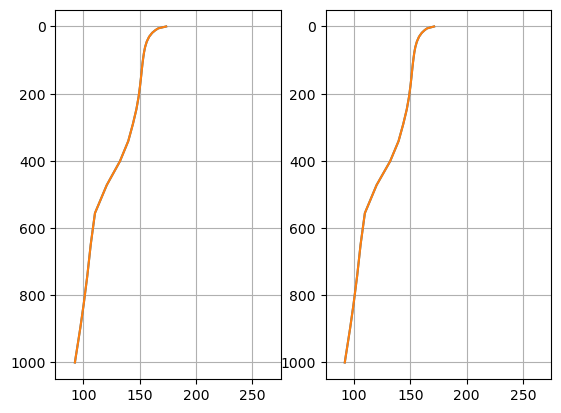

In [14]:
fig,axes = plt.subplots(1,2)

axes[0].plot(climlab.to_xarray(radmodel_sw.SW_flux_net),p_lev)
axes[0].plot(climlab.to_xarray(radmodel_lw.LW_flux_net),p_lev)
axes[0].set_xlim(75,275)
axes[0].invert_yaxis()
axes[0].grid()

axes[1].plot(climlab.to_xarray(radmodel_comb.SW_flux_net),p_lev)
axes[1].plot(climlab.to_xarray(radmodel_comb.LW_flux_net),p_lev)
axes[1].set_xlim(75,275)
axes[1].invert_yaxis()
axes[1].grid()

redefine models for manual McICA again

In [15]:
# define Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random 3: Maximum
ICLD = 1
# The same model initialized as above
mystate = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
radmodel_sw = climlab.radiation.RRTMG_SW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )
radmodel_lw = climlab.radiation.RRTMG_LW(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=Qglobal.values,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                              icld = ICLD,
                              **mycloud
                             )

In [18]:
# Use 20 mcica samples per iteration for manual iteration and compare with one sample default model again.
count = 0
nmcica = 20
while True:
    step_model(radmodel_sw,radmodel_lw,nmcica)
    asr = radmodel_sw.diagnostics['ASR']
    olr = radmodel_lw.diagnostics['OLR']
    count += 1
    if count > 1000 or np.abs(asr-olr)<0.01:
        break
count

775

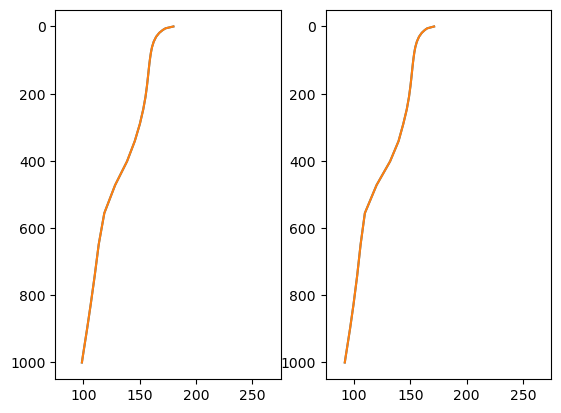

In [19]:
fig,axes = plt.subplots(1,2)

axes[0].plot(climlab.to_xarray(radmodel_sw.SW_flux_net),p_lev)
axes[0].plot(climlab.to_xarray(radmodel_lw.LW_flux_net),p_lev)
axes[0].set_xlim(75,275)
axes[0].invert_yaxis()
axes[0].grid()

axes[1].plot(climlab.to_xarray(radmodel_comb.SW_flux_net),p_lev)
axes[1].plot(climlab.to_xarray(radmodel_comb.LW_flux_net),p_lev)
axes[1].set_xlim(75,275)
axes[1].invert_yaxis()
axes[0].grid()

Note the difference is the most noticable near bottom levels

Try different cloud overlap methods or nmcica?